In [69]:
import os
print("cwd =", os.getcwd())
print("files =", os.listdir("."))


cwd = /Users/lancy/Desktop/:Users:lancy:Desktop:lancy_slash_project:/lancy-s
files = ['.DS_Store', 'lancy_slash_sample.ipynb', '.gitignore', 'roc_auc_plot.png', '.git', 'fannie_mae_sample_300k_raw.csv']


In [70]:
from dotenv import load_dotenv
load_dotenv("/Users/lancy/Desktop/.env", override=True)

import os
print(os.getenv("DB_HOST"))


db.ptukzshzuloxipzwycte.supabase.co


In [71]:
import socket
print(socket.getaddrinfo("db.ptukzshzuloxipzwycte.supabase.co", 5432))


[(<AddressFamily.AF_INET6: 30>, <SocketKind.SOCK_DGRAM: 2>, 17, '', ('2600:1f1c:f9:4d08:b478:2bbb:222d:8d0d', 5432, 0, 0)), (<AddressFamily.AF_INET6: 30>, <SocketKind.SOCK_STREAM: 1>, 6, '', ('2600:1f1c:f9:4d08:b478:2bbb:222d:8d0d', 5432, 0, 0))]


In [72]:
import os, socket, psycopg2
from dotenv import load_dotenv

load_dotenv("/Users/lancy/Desktop/.env", override=True)

host = os.getenv("DB_HOST")
port = int(os.getenv("DB_PORT", "5432"))

ipv6 = socket.getaddrinfo(host, port, socket.AF_INET6, socket.SOCK_STREAM)[0][4][0]
print("Using IPv6 =", ipv6)

conn = psycopg2.connect(
    host=host,
    hostaddr=ipv6,
    port=port,
    dbname=os.getenv("DB_NAME", "postgres"),
    user=os.getenv("DB_USER", "postgres"),
    password=os.getenv("DB_PASSWORD"),
    sslmode="require",
    connect_timeout=10,
)
print("✅ Connected!")


Using IPv6 = 2600:1f1c:f9:4d08:b478:2bbb:222d:8d0d
✅ Connected!


In [73]:
import pandas as pd

query = """
SELECT *
FROM fannie_mae_cas_raw
TABLESAMPLE SYSTEM (5)
LIMIT 300000;
"""
df = pd.read_sql(query, conn)
print(df.shape)



/var/folders/g1/xtt32sq56_b6b6bts7mwbmxr0000gn/T/ipykernel_60413/130975378.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


(300000, 110)


In [74]:
#1 
df.to_csv(
    "fannie_mae_sample_300k_raw.csv",
    index=False
)


In [75]:
df_clean = df.copy()

# 看缺失情况
missing = df_clean.isna().mean().sort_values(ascending=False)
print(missing.head(10))


interest_only_first_principal_and_interest_payment_date    1.0
months_to_amortization                                     1.0
arm_product_type                                           1.0
index                                                      1.0
next_interest_rate_adjustment_date                         1.0
arm_cap_structure                                          1.0
lifetime_interest_rate_cap_up_percent                      1.0
periodic_interest_rate_cap_up_percent                      1.0
arm_plan_number                                            1.0
mortgage_margin                                            1.0
dtype: float64


In [76]:
# 删除 100% 缺失的列
cols_all_missing = missing[missing == 1.0].index
df_clean = df_clean.drop(columns=cols_all_missing)

print(f"Dropped {len(cols_all_missing)} columns with 100% missing values")


Dropped 16 columns with 100% missing values


In [77]:
missing[missing.between(0.05, 0.9)].head(20)


mortgage_insurance_percentage                    0.665343
mortgage_insurance_type                          0.665343
mortgage_insurance_cancellation_indicator        0.665343
co_borrower_credit_score_current                 0.596440
co_borrower_credit_score_at_issuance             0.576823
co_borrower_credit_score_at_origination          0.576370
interest_bearing_upb                             0.376853
payment_deferral_modification_event_indicator    0.334660
borrower_credit_score_current                    0.051137
dtype: float64

In [78]:
from sklearn.impute import SimpleImputer

# ---------- 1️⃣ 明确列分组 ----------

# A. mortgage insurance 相关（缺失 = 无）
mi_cols = [
    "mortgage_insurance_percentage",
    "mortgage_insurance_type",
    "mortgage_insurance_cancellation_indicator",
]

# B. co-borrower credit score（数值）
co_borrower_score_cols = [
    "co_borrower_credit_score_current",
    "co_borrower_credit_score_at_issuance",
    "co_borrower_credit_score_at_origination",
]

# C. 其他数值型（用 median）
median_numeric_cols = [
    "interest_bearing_upb",
    "borrower_credit_score_current",
]

# ---------- 2️⃣ 分别填补 ----------

# A. mortgage insurance A 类：是否存在型变量（缺失本身有意义）0填
df_clean[mi_cols] = df_clean[mi_cols].fillna(
    {
        "mortgage_insurance_percentage": 0,
        "mortgage_insurance_type": "None",
        "mortgage_insurance_cancellation_indicator": 0,
    }
)

# B. co-borrower credit scores → median B 类：信用分数（数值型）median填
median_imputer = SimpleImputer(strategy="median")
df_clean[co_borrower_score_cols] = median_imputer.fit_transform(
    df_clean[co_borrower_score_cols]
)

# C. 其他数值型 → median C 类：金额型（UPB）median填
df_clean[median_numeric_cols] = median_imputer.fit_transform(
    df_clean[median_numeric_cols]
)

print("✅ Partial missing columns imputed")


✅ Partial missing columns imputed


In [79]:
df_clean[mi_cols + co_borrower_score_cols + median_numeric_cols].isna().mean()


mortgage_insurance_percentage                0.0
mortgage_insurance_type                      0.0
mortgage_insurance_cancellation_indicator    0.0
co_borrower_credit_score_current             0.0
co_borrower_credit_score_at_issuance         0.0
co_borrower_credit_score_at_origination      0.0
interest_bearing_upb                         0.0
borrower_credit_score_current                0.0
dtype: float64

In [80]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# 数值型 & 类别型列
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df_clean.select_dtypes(include=["object", "category"]).columns

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))


Numeric columns: 5
Categorical columns: 89


In [81]:
from sklearn.preprocessing import StandardScaler
#数值列填median
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)


In [82]:
cat_cols = df_clean.select_dtypes(include=["object", "category"]).columns
print(f"Categorical columns ({len(cat_cols)}):")
cat_cols

for col in cat_cols:
    print(f"\n=== {col} ===")
    print(df_clean[col].value_counts(dropna=False).head(10))


Categorical columns (89):

=== reference_pool_id ===
reference_pool_id
5350    101663
5361    100519
5353     97607
5363       211
Name: count, dtype: int64

=== loan_identifier ===
loan_identifier
134297228    8
134297227    8
134297226    8
134645756    7
134645755    7
134645753    7
134634173    7
134264713    7
134264714    7
134264715    7
Name: count, dtype: int64

=== monthly_reporting_period ===
monthly_reporting_period
122024    12903
42023     12837
52023     12473
32025     12458
112024    12424
32024     12363
12025     12341
22025     12335
22024     12307
12024     12300
Name: count, dtype: int64

=== channel ===
channel
R    201901
C     58455
B     39644
Name: count, dtype: int64

=== seller_name ===
seller_name
Other                                        133669
Rocket Mortgage, LLC                          30527
United Wholesale Mortgage, LLC                16604
Wells Fargo Bank, N.A.                        11340
JPMorgan Chase Bank, National Association      8502
l

In [83]:
df_clean.select_dtypes(include=["object","category"]).nunique().sort_values(ascending=False).head(20)


current_actual_upb                      269319
loan_identifier                         171952
upb_at_issuance                         145820
total_principal_current                 107556
scheduled_principal_current             101105
unscheduled_principal_current            21146
upb_at_the_time_of_removal                9822
loan_payment_history                      4314
original_interest_rate                    1606
current_interest_rate                     1585
original_upb                              1007
zip_code_short                             883
total_deferral_amount                      557
remaining_months_to_maturity               457
metropolitan_statistical_area_msa          393
borrower_credit_score_at_origination       232
remaining_months_to_legal_maturity         193
maturity_date                              162
cumulative_modification_loss_amount        102
original_loan_term                          90
dtype: int64

In [84]:
#明确“真正的 categorical 能onehot的
cat_cols = (
    df_clean
    .select_dtypes(include=["object","category"])
    .columns
)

# 用 unique 数过滤
cat_cardinality = df_clean[cat_cols].nunique()

# 只保留低基数 categorical
LOW_CARD_MAX = 50
true_cat_cols = cat_cardinality[cat_cardinality <= LOW_CARD_MAX].index.tolist()

print("True categorical cols (for One-Hot):")
print(true_cat_cols)


True categorical cols (for One-Hot):
['reference_pool_id', 'monthly_reporting_period', 'channel', 'seller_name', 'servicer_name', 'master_servicer', 'origination_date', 'first_payment_date', 'original_loan_to_value_ratio_ltv', 'original_combined_loan_to_value_ratio_cltv', 'number_of_borrowers', 'first_time_home_buyer_indicator', 'loan_purpose', 'property_type', 'number_of_units', 'occupancy_status', 'mortgage_insurance_percentage', 'amortization_type', 'prepayment_penalty_indicator', 'interest_only_loan_indicator', 'current_loan_delinquency_status', 'modification_flag', 'mortgage_insurance_cancellation_indicator', 'zero_balance_code', 'zero_balance_effective_date', 'last_paid_installment_date', 'foreclosure_date', 'disposition_date', 'foreclosure_costs', 'property_preservation_and_repair_costs', 'asset_recovery_costs', 'miscellaneous_holding_expenses_and_credits', 'associated_taxes_for_holding_property', 'net_sales_proceeds', 'credit_enhancement_proceeds', 'repurchase_make_whole_procee

In [85]:
#把“假 categorical”转回数值 or 删除
numeric_like_cols = [
    "current_actual_upb",
    "upb_at_issuance",
    "total_principal_current",
    "scheduled_principal_current",
    "unscheduled_principal_current",
    "original_interest_rate",
    "current_interest_rate",
    "original_upb",
]

for c in numeric_like_cols:
    df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")


In [86]:
#id类全drop（保留 loan_identifier 供 Safe model 去重使用）
id_like_cols = [
    "loan_payment_history",
]

df_clean = df_clean.drop(columns=id_like_cols)


In [87]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

TARGET = "zero_balance_code"

# 1) 先构造 y 和 X（非常关键：列清单必须基于最终 X）
df_model = df_clean.copy()
z = pd.to_numeric(df_model[TARGET], errors="coerce")
y = ((~z.isna()) & (z != 0)).astype(int)

# 建议同时移除可能泄漏的日期列（可选但推荐）
leak_cols = ["zero_balance_effective_date", "zero_balance_code_change_date"]
drop_cols = [TARGET] + [c for c in leak_cols if c in df_model.columns]

X = df_model.drop(columns=drop_cols)

# 2) 在 X 上重新算列类型（不要用 df_clean）
num_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("num:", len(num_cols), "cat:", len(cat_cols))

# 3) 预处理（RF 不需要 scaler，所以数值只 impute 就够）
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("to_str", FunctionTransformer(lambda X: X.astype(str), validate=False)),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)


num: 13 cat: 76


In [88]:
import pandas as pd
import numpy as np

TARGET = "zero_balance_code"

# 1) 先构造标签 y
df_model = df_clean.copy()
z = pd.to_numeric(df_model[TARGET], errors="coerce")

# 这里的规则你也可以改：非空且 != 0 视为 “发生 zero balance（还清/终止）”
y = ((~z.isna()) & (z != 0)).astype(int)
print("Label distribution:\n", y.value_counts())

# 2) 再构造特征 X（一定要把 target 列从特征里去掉）
X = df_model.drop(columns=[TARGET])

# 3) 关键：基于 X 重新计算列类型（不要用旧的 num_cols/cat_cols）
num_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("num cols:", len(num_cols), "cat cols:", len(cat_cols))
print("Does TARGET appear in cols lists?",
      TARGET in num_cols, TARGET in cat_cols)  # 应该都是 False


Label distribution:
 zero_balance_code
0    285962
1     14038
Name: count, dtype: int64
num cols: 13 cat cols: 78
Does TARGET appear in cols lists? False False


In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

TARGET = "zero_balance_code"

# 1) 构造 y
df_model = df_clean.copy()
z = pd.to_numeric(df_model[TARGET], errors="coerce")
y = ((~z.isna()) & (z != 0)).astype(int)

# 2) 构造 X（去掉 target + 建议去掉泄漏日期列）
leak_cols = ["zero_balance_effective_date", "zero_balance_code_change_date"]
drop_cols = [TARGET] + [c for c in leak_cols if c in df_model.columns]
X = df_model.drop(columns=drop_cols)

# 3) 列类型（必须基于 X）
num_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# ✅ 关键硬修复：把所有 cat 列统一成字符串（彻底杜绝 int/str 混合）
X[cat_cols] = X[cat_cols].astype("string")
# 用一个明确的占位符处理缺失（这样 onehot 会把它当成一个类别）
X[cat_cols] = X[cat_cols].fillna("MISSING")

print("num:", len(num_cols), "cat:", len(cat_cols))

# 4) 预处理
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline([
    # 这里 imputer 可有可无（你已经 fillna 了），保留也没问题
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

# 5) 切分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6) Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced",
    min_samples_leaf=50,
)

model = Pipeline([
    ("preprocess", preprocessor),
    ("rf", rf),
])

model.fit(X_train, y_train)
print("✅ Random Forest trained")


num: 13 cat: 76
✅ Random Forest trained


In [90]:
# 7) 构建预处理管道
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),  # RF 其实不需要，但加上也无妨
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

# 8) 随机森林模型
rf = RandomForestClassifier(
    n_estimators=400,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced",  # 处理类别不平衡
    min_samples_leaf=50,
    max_depth=15,  # 限制深度防止过拟合
)

model_origination = Pipeline([
    ("preprocess", preprocessor),
    ("rf", rf),
])

# 9) 训练
print("开始训练模型（只用发放时特征）...")
model_origination.fit(X_train, y_train)
print("✅ 训练完成！")

开始训练模型（只用发放时特征）...
✅ 训练完成！


In [91]:
# 11) 查看特征重要性（无需 matplotlib）

# 获取特征名
feature_names = model_origination.named_steps['preprocess'].get_feature_names_out()
importances = model_origination.named_steps['rf'].feature_importances_

# 创建 DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# 显示 Top 20 重要特征
print("=" * 60)
print("🔍 Top 20 最重要特征")
print("=" * 60)
print(importance_df.head(20).to_string(index=False))

🔍 Top 20 最重要特征
                                         feature  importance
                           cat__loan_age_MISSING    0.062201
                      cat__maturity_date_MISSING    0.058912
       cat__servicing_activity_indicator_MISSING    0.055362
       cat__remaining_months_to_maturity_MISSING    0.054683
                        cat__modification_flag_N    0.052869
             cat__servicing_activity_indicator_N    0.051506
 cat__remaining_months_to_legal_maturity_MISSING    0.050302
                  cat__modification_flag_MISSING    0.050039
cat__repurchase_make_whole_proceeds_flag_MISSING    0.049494
                num__scheduled_principal_current    0.043319
      cat__repurchase_make_whole_proceeds_flag_N    0.042420
                      cat__servicer_name_MISSING    0.041820
        cat__current_loan_delinquency_status_0.0    0.041205
    cat__current_loan_delinquency_status_MISSING    0.040657
                         num__current_actual_upb    0.039976
         

In [95]:
# 12) 混淆矩阵（纯文字版本，无需 matplotlib）
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)

print("=" * 60)
print("📊 混淆矩阵 (Confusion Matrix)")
print("=" * 60)
print()
print("                 预测值")
print("              正常(0)  终止(1)")
print(f"实际 正常(0)   {cm[0,0]:>6}   {cm[0,1]:>6}")
print(f"     终止(1)   {cm[1,0]:>6}   {cm[1,1]:>6}")
print()

# 计算各项指标
tn, fp, fn, tp = cm.ravel()
print("=" * 60)
print("📈 详细指标")
print("=" * 60)
print(f"True Negatives (TN):  {tn:>6}  - 正确预测为正常")
print(f"False Positives (FP): {fp:>6}  - 误报为终止")
print(f"False Negatives (FN): {fn:>6}  - 漏报（实际终止但预测正常）")
print(f"True Positives (TP):  {tp:>6}  - 正确预测为终止")
print()

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"Sensitivity (Recall): {sensitivity:.4f}  - 终止贷款的识别率")
print(f"Specificity:          {specificity:.4f}  - 正常贷款的识别率")

print()
print("=" * 60)
print("📝 说明")
print("=" * 60)
print("- 如果 ROC-AUC 在 0.65-0.80 之间，这是房贷违约预测的正常水平")
print("- 如果 ROC-AUC > 0.95，可能还有隐藏的数据泄漏")

📊 混淆矩阵 (Confusion Matrix)

                 预测值
              正常(0)  终止(1)
实际 正常(0)    54505     2687
     终止(1)     2673      135

📈 详细指标
True Negatives (TN):   54505  - 正确预测为正常
False Positives (FP):   2687  - 误报为终止
False Negatives (FN):   2673  - 漏报（实际终止但预测正常）
True Positives (TP):     135  - 正确预测为终止

Sensitivity (Recall): 0.0481  - 终止贷款的识别率
Specificity:          0.9530  - 正常贷款的识别率

📝 说明
- 如果 ROC-AUC 在 0.65-0.80 之间，这是房贷违约预测的正常水平
- 如果 ROC-AUC > 0.95，可能还有隐藏的数据泄漏


In [100]:
# ============================================
# 🔒 更严格版本：只用绝对安全的发放时特征
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

TARGET = "zero_balance_code"

# 1) 构造标签 y
df_model = df_clean.copy()
z = pd.to_numeric(df_model[TARGET], errors="coerce")
y = ((~z.isna()) & (z != 0)).astype(int)

# 2) 🔒 只保留绝对安全的发放时静态特征（排除所有日期和可能变化的字段）
safe_origination_features = [
    # 贷款金额（发放时固定）
    "original_upb",
    
    # 利率（发放时固定）
    "original_interest_rate",
    
    # LTV（发放时固定）
    "original_loan_to_value_ratio_ltv",
    "original_combined_loan_to_value_ratio_cltv",
    
    # 信用分数（发放时）
    "borrower_credit_score_at_origination",
    "co_borrower_credit_score_at_origination",
    
    # 借款人信息（发放时固定）
    "number_of_borrowers",
    "first_time_home_buyer_indicator",
    
    # 贷款类型信息（发放时固定）
    "loan_purpose",
    "channel",
    "amortization_type",
    
    # 房产信息（发放时固定）
    "property_type",
    "number_of_units",
    "occupancy_status",
    
    # 保险（发放时）
    "mortgage_insurance_percentage",
]

# 只保留数据集中存在的列
available_features = [c for c in safe_origination_features if c in df_model.columns]
print(f"✅ 使用的安全特征数量: {len(available_features)}")
print(f"特征列表: {available_features}")

# 3) 关键：每笔贷款只保留第一条记录（发放时的快照），使用 loan-level 标签
# 按优先级搜索 loan 标识列
LOAN_ID_CANDIDATES = [
    'loan_identifier', 'loan_id', 'id',
    'acq_loan_identifier', 'acq_loan_id',  # Fannie Mae acquisition
]
loan_id_col = None
for col in LOAN_ID_CANDIDATES:
    if col in df_model.columns:
        loan_id_col = col
        break

# Fallback: 若无 ID 列，用 origination 列构造合成 key（fillna(0) 后 astype(str) 再 join）
if loan_id_col is None:
    synth_cols = [
        'original_upb', 'original_interest_rate', 'borrower_credit_score_at_origination',
        'origination_date', 'first_payment_date',  # if exists
    ]
    present = [c for c in synth_cols if c in df_model.columns]
    if present:
        df_model['_synthetic_loan_id'] = (
            df_model[present]
            .fillna(0)
            .astype(str)
            .agg('_'.join, axis=1)
        )
        loan_id_col = '_synthetic_loan_id'
        print("⚠️ 未找到 loan ID 列，使用合成 key:", present)
    else:
        # 最后兜底：用行索引作为 key，避免 ValueError 阻塞执行
        df_model['_synthetic_loan_id'] = df_model.index.astype(str)
        loan_id_col = '_synthetic_loan_id'
        print("⚠️ 无 origination 列可用，使用行索引作为 fallback key")

# 1) 计算 loan-level 标签：该贷款是否曾达到零余额（对行级 y 按 loan 取 max）
loan_final_y = pd.Series(y.values, index=df_model[loan_id_col].values).groupby(level=0).max()

# 2) 每笔贷款保留一行（按 loan_id_col 去重）
df_model_dedup = df_model.drop_duplicates(subset=[loan_id_col], keep='first')
print(f"\n原始数据行数: {len(df_model)}")
print(f"去重后行数（每笔贷款一行）: {len(df_model_dedup)}")

# 3) 重新构造 X 和 y（基于去重后的数据，y 使用 loan-level 标签）
X = df_model_dedup[available_features].copy()
y = loan_final_y.loc[df_model_dedup[loan_id_col]].values

print(f"\n标签分布:")
print(pd.Series(y).value_counts())

✅ 使用的安全特征数量: 15
特征列表: ['original_upb', 'original_interest_rate', 'original_loan_to_value_ratio_ltv', 'original_combined_loan_to_value_ratio_cltv', 'borrower_credit_score_at_origination', 'co_borrower_credit_score_at_origination', 'number_of_borrowers', 'first_time_home_buyer_indicator', 'loan_purpose', 'channel', 'amortization_type', 'property_type', 'number_of_units', 'occupancy_status', 'mortgage_insurance_percentage']
⚠️ 未找到 loan ID 列，使用合成 key: ['original_upb', 'original_interest_rate', 'borrower_credit_score_at_origination', 'origination_date', 'first_payment_date']

原始数据行数: 300000
去重后行数（每笔贷款一行）: 167492

标签分布:
0    157654
1      9838
Name: count, dtype: int64


In [101]:
# 4) 列类型
num_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print(f"数值列 ({len(num_cols)}): {num_cols}")
print(f"类别列 ({len(cat_cols)}): {cat_cols}")

# 5) 类别列统一处理
X[cat_cols] = X[cat_cols].astype("string").fillna("MISSING")

# 6) 划分数据
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n训练集: {X_train.shape}, 测试集: {X_test.shape}")

# 7) 构建预处理管道
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

# 8) 随机森林模型
rf = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced",
    min_samples_leaf=50,
    max_depth=10,
)

model_safe = Pipeline([
    ("preprocess", preprocessor),
    ("rf", rf),
])

# 9) 训练
print("\n开始训练模型（严格安全特征版本）...")
model_safe.fit(X_train, y_train)
print("✅ 训练完成！")

数值列 (3): ['original_upb', 'original_interest_rate', 'co_borrower_credit_score_at_origination']
类别列 (12): ['original_loan_to_value_ratio_ltv', 'original_combined_loan_to_value_ratio_cltv', 'borrower_credit_score_at_origination', 'number_of_borrowers', 'first_time_home_buyer_indicator', 'loan_purpose', 'channel', 'amortization_type', 'property_type', 'number_of_units', 'occupancy_status', 'mortgage_insurance_percentage']

训练集: (133993, 15), 测试集: (33499, 15)

开始训练模型（严格安全特征版本）...
✅ 训练完成！


In [102]:
# 10) 评估模型
proba = model_safe.predict_proba(X_test)[:, 1]
pred = model_safe.predict(X_test)

roc_auc = roc_auc_score(y_test, proba)

print("=" * 60)
print("📊 严格安全特征版本的模型结果")
print("=" * 60)
print(f"\n🎯 ROC-AUC: {roc_auc:.4f}")
print("\n分类报告:")
print(classification_report(y_test, pred))

# 混淆矩阵
cm = confusion_matrix(y_test, pred)
print("=" * 60)
print("📊 混淆矩阵")
print("=" * 60)
print(f"\n              预测值")
print(f"           正常(0)  终止(1)")
print(f"实际 正常(0) {cm[0,0]:>6}   {cm[0,1]:>6}")
print(f"     终止(1) {cm[1,0]:>6}   {cm[1,1]:>6}")

# 结果解读
print("\n" + "=" * 60)
print("📝 结果解读")
print("=" * 60)
if roc_auc > 0.99:
    print("⚠️  ROC-AUC 仍然接近 1.0！")
    print("    可能原因：")
    print("    1. 数据中同一笔贷款的多条记录导致信息泄漏")
    print("    2. 目标变量的定义本身有问题")
    print("    3. 某些特征在贷款终止后被回填")
elif roc_auc > 0.95:
    print("⚠️  ROC-AUC > 0.95，仍然偏高，可能存在轻微泄漏")
elif roc_auc > 0.80:
    print("✅ ROC-AUC 在 0.80-0.95 之间，比较合理但偏高")
else:
    print("✅ ROC-AUC 在正常范围内！这是真实的预测能力。")

📊 严格安全特征版本的模型结果

🎯 ROC-AUC: 0.6051

分类报告:
              precision    recall  f1-score   support

           0       0.96      0.47      0.63     31531
           1       0.07      0.68      0.14      1968

    accuracy                           0.49     33499
   macro avg       0.52      0.58      0.38     33499
weighted avg       0.91      0.49      0.61     33499

📊 混淆矩阵

              预测值
           正常(0)  终止(1)
实际 正常(0)  14943    16588
     终止(1)    624     1344

📝 结果解读
✅ ROC-AUC 在正常范围内！这是真实的预测能力。


In [106]:
# MLP Model Training (using same X, y as Safe model)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# 1) Use existing X and y from Safe model; same split for consistency
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Use Safe model's preprocessor to get scaled numeric features (impute + scale + one-hot)
X_train_scaled = model_safe.named_steps['preprocess'].transform(X_train)
X_test_scaled = model_safe.named_steps['preprocess'].transform(X_test)
# Convert to dense if sparse (MLPClassifier works with both)
import numpy as np
if hasattr(X_train_scaled, 'toarray'):
    X_train_scaled = X_train_scaled.toarray()
    X_test_scaled = X_test_scaled.toarray()

# 3) MLP model
model_mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    max_iter=200,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

# 4) Train
model_mlp.fit(X_train_scaled, y_train)

# 5) Predict and evaluate
proba_mlp = model_mlp.predict_proba(X_test_scaled)[:, 1]
roc_auc_mlp = roc_auc_score(y_test, proba_mlp)
pred_mlp = model_mlp.predict(X_test_scaled)

# 6) Print MLP Architecture, ROC-AUC, classification_report, confusion_matrix
print("=" * 60)
print("📊 MLP Model Results")
print("=" * 60)
print(f"\nMLP Architecture: Input({X_train_scaled.shape[1]}) -> 64 -> 32 -> 1 (binary)")
print(f"\n🎯 ROC-AUC: {roc_auc_mlp:.4f}")
print("\n分类报告:")
print(classification_report(y_test, pred_mlp))
cm_mlp = confusion_matrix(y_test, pred_mlp)
print("混淆矩阵:")
print(f"              预测值")
print(f"           正常(0)  终止(1)")
print(f"实际 正常(0) {cm_mlp[0,0]:>6}   {cm_mlp[0,1]:>6}")
print(f"     终止(1) {cm_mlp[1,0]:>6}   {cm_mlp[1,1]:>6}")

# 7) Optional: Plot ROC + MLP combined figure and save
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, proba_mlp)
roc_auc_val = auc(fpr_mlp, tpr_mlp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# LEFT: MLP architecture
n_features = X_train_scaled.shape[1]
layer_sizes = [n_features, 64, 32, 1]
ax1.set_xlim(-0.5, len(layer_sizes) - 0.5)
ax1.set_ylim(-1.2, 1.2)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title('MLP Architecture (Binary Classification)', fontsize=12)
layer_names = [f'Input\n(n={layer_sizes[0]})', 'Hidden 1\n(64)', 'Hidden 2\n(32)', 'Output\n(1)']
for i, (n, name) in enumerate(zip(layer_sizes, layer_names)):
    y_pos = 0.5 - i * 0.4
    for j in range(min(n, 8)):
        y_off = (j - min(n, 8) / 2) * 0.12
        circle = plt.Circle((i, y_pos + y_off), 0.08, color='steelblue', fill=True, ec='navy', lw=0.5)
        ax1.add_patch(circle)
    if n > 8:
        ax1.text(i, y_pos - 0.35, '...', ha='center', fontsize=10)
    ax1.text(i, -0.9, name, ha='center', va='top', fontsize=9)

# RIGHT: ROC curve
ax2.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label=f'MLP ROC (AUC = {roc_auc_val:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve (MLP Model)')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_mlp_combined.png', dpi=150, bbox_inches='tight')
plt.close()
print('\nSaved roc_mlp_combined.png')

📊 MLP Model Results

MLP Architecture: Input(345) -> 64 -> 32 -> 1 (binary)

🎯 ROC-AUC: 0.6024

分类报告:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     31531
           1       0.00      0.00      0.00      1968

    accuracy                           0.94     33499
   macro avg       0.47      0.50      0.48     33499
weighted avg       0.89      0.94      0.91     33499



/Users/lancy/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lancy/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/lancy/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

混淆矩阵:
              预测值
           正常(0)  终止(1)
实际 正常(0)  31531        0
     终止(1)   1968        0

Saved roc_mlp_combined.png


In [105]:
# Combined MLP architecture diagram + ROC curve (Safe model)
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Use existing y_test and proba from Safe model
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc_val = auc(fpr, tpr)

# MLP layer sizes: [input, 64, 32, 1] for binary classification
try:
    n_features = len(available_features)
except NameError:
    n_features = 10
layer_sizes = [n_features, 64, 32, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# LEFT: MLP architecture diagram
ax1.set_xlim(-0.5, len(layer_sizes) - 0.5)
ax1.set_ylim(-1.2, 1.2)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title('MLP Architecture (Binary Classification)', fontsize=12)

layer_names = ['Input\n(n={})'.format(layer_sizes[0]), 'Hidden 1\n(64)', 'Hidden 2\n(32)', 'Output\n(1)']
for i, (n, name) in enumerate(zip(layer_sizes, layer_names)):
    y_pos = 0.5 - i * 0.4
    for j in range(min(n, 8)):  # draw up to 8 nodes per layer
        y_off = (j - min(n, 8) / 2) * 0.12
        circle = plt.Circle((i, y_pos + y_off), 0.08, color='steelblue', fill=True, ec='navy', lw=0.5)
        ax1.add_patch(circle)
    if n > 8:
        ax1.text(i, y_pos - 0.35, '...', ha='center', fontsize=10)
    ax1.text(i, -0.9, name, ha='center', va='top', fontsize=9)
# Draw connections between layers
for i in range(len(layer_sizes) - 1):
    ax1.plot([i + 0.15, i + 0.85], [0.3, 0.3], 'gray', lw=0.5, alpha=0.6)

# RIGHT: ROC curve
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve (Safe Model)')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_mlp_combined.png', dpi=150, bbox_inches='tight')
plt.close()
print('Saved roc_mlp_combined.png')

Saved roc_mlp_combined.png


In [ ]:
(128, 64)
(64, 32)
(32, 16)


(32, 16)

In [ ]:
alpha = 1e-3
alpha = 1e-4
alpha = 1e-5


In [ ]:
from sklearn.linear_model import LogisticRegression


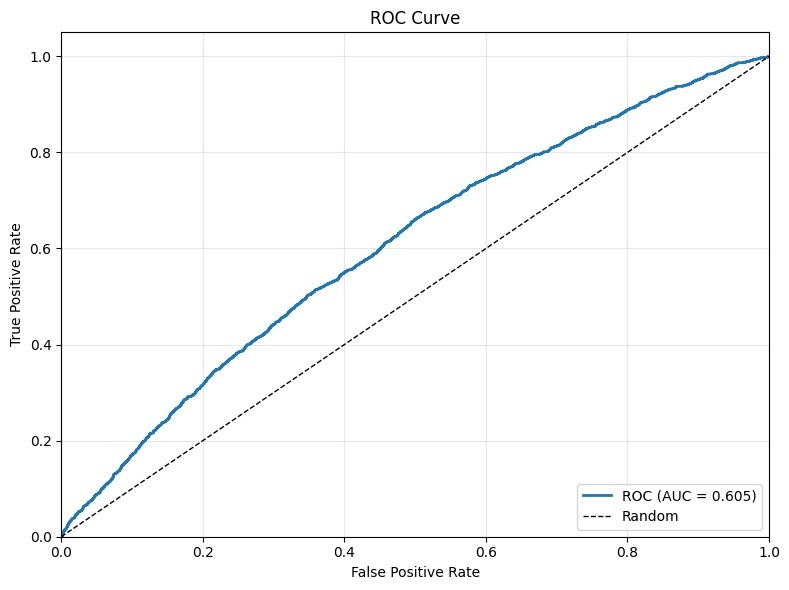

In [104]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_auc_plot.png', dpi=150, bbox_inches='tight')
plt.show()